
**Wykorzystane techniki**:
- regresja liniowa
- drewo decyzyjne
- analiza rozkładu zmiennej -> rozkład naturalny
- klastrowanie -> algorytm K-Means z metodą wykresu łokciowego

# Struktura projektu - spis treści

 [1. Importowanie bibliotek](#1.-Importowanie-bibliotek) <br>
 [2. Wczytywanie danych](#2.-Wczytywanie-danych) <br>
 [3. Oczyszczanie danych](#3.-Oczyszczanie-danych)

&emsp;[3.1. Plik gminy.csv](#3.1.-Plik-gminy.csv)<br>
   - unikalne wartości kolumny "Kategoria"
   - pivot_table() dla lepszego zobrazowania powiązań kolumn "Kategoria" i "Zmienna"
   - Braki danych (NaN)
   - Podział ramki danych wzgl. kolumny "Kategoria"
   - wartości podejrzane

&emsp;[3.2. Plik ludnosc.csv](#3.2.-Plik-ludnosc.csv)
    - analigocznie jak w p. 3.1

[4. Analiza danych](#4.-Analiza-danych) <br>

&emsp;[4.1. Regresja liniowa](#4.1.-Regresja-liniowa)
- <u>Pytanie 1</u>: Czy wydatki są liniowo skorelowane z dochodami?, Czy wydatki zależą od dochodów?
- <u>Pytanie 2</u>: Czy spożycie napojów alkoholowych i wyrobów tytoniowych zależy od pobierania świadczenia 500+?
- <u>Pytanie 3</u>: Czy wydatki na zdrowie będą zależeć od dochodów do dyspozycji?
<br>
Regresja liniowa dla pytania 3.
    
&emsp;[4.2. Drzewo decyzyjne](#4.2.-Drzewo-decyzyjne)
- <u>Propozycja drzewa 1</u>: Wydatki, Dochody -> Bezrobocie
- <u> Propozycja drzewa 2</u>: Dochody per capita, ludność na 1 km2, Wydatki na oświatę -> Skolaryzacja

&emsp;[4.3. Analiza rozkładu zmiennej](#4.3.-Analiza-rozkładu-zmiennej)
- Średnie wydatki miesięczne w latach 2016-2020

&emsp;[4.4. Algorytm K-Means](#4.4.-Algorytm-K-Means)
- Bezrobocie, dochody

# 1. Importowanie bibliotek

In [92]:
import pandas as pd
import numpy as np
from numpy import mean
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

import scipy.stats as st
from scipy.stats import linregress, t, shapiro
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

# 2. Wczytywanie danych

In [3]:
!wget -nv -O gminy.csv "https://www.dropbox.com/s/vk5mcn365d5rlwx/gminy.csv?dl=0"
!wget -nv -O ludnosc.csv "https://www.dropbox.com/s/sxig1h9x79or3gc/ludnosc.csv?dl=0"
!wget -nv -O TERC.csv "https://www.dropbox.com/s/kg6liy5czznkhlv/TERC.csv?dl=0"

2022-01-14 11:56:28 URL:https://ucb6bbcbf95f19093a1cf7f0cb48.dl.dropboxusercontent.com/cd/0/inline/Bdyeujh-2BmZYooez1Yfu3T-OuhislnIEDcT-Zwa325RVvtUIF17nOlil3qCjP3JyDrKDhZX3hqKKaHaR1I0n1WZLWvEIj_BOUEA7aNwpISISKS2K4UmFUxBVhNg79fK_aiJLmgeoUASD2bHROCBeWsK/file [177922457/177922457] -> "gminy.csv" [1]
2022-01-14 11:56:30 URL:https://ucb59f33efe2550f5de881edd0c4.dl.dropboxusercontent.com/cd/0/inline/BdwPFBbcl0ZJzN-Vy69IuARLUx2YvhOhcHmYKBD4SdLuxVlrWFZHUyox1WW86B9IqMYWNmsMe0s9TCtao4cRwQOyYd21CW9kdgQR-TSFB9o4XSI3OxbMWWlWMOSS37eLyA5ATh8HvxZ-HmDdTQZXnMkV/file [2299345/2299345] -> "ludnosc.csv" [1]
2022-01-14 11:56:32 URL:https://ucdfd7adb9dcc61ff9ee851adb95.dl.dropboxusercontent.com/cd/0/inline/BdzWa50Dz9qYUi1vJqJoCJIZ-3bM71zwLWzUgUDyacmWpk297EGW32dY8Bo7iT1wsz6FjfpuIaJ2pVCWCV6DMu5Hrn8c60gqD6hfE9W8jCjilOfwC6v5kGu8N5OLfLx9A5h6Zv6GPP2GuXJgGt0aP-Gn/file [194222/194222] -> "TERC.csv" [1]


https://drive.google.com/drive/folders/1Do9RG7jP783ze7TqwZ__zzENnJi3jb2f?usp=sharing

Wszystkie pliki CSV z danymi mają identyczny format.
- plik **ludnosc.csv**: wyniki ankiet w gospodarstwach domowych, zagregowane po województwach
- plik **gminy.csv**: dane statystyczne na temat gmin
- plik **TERT.csv**: dodatkowe dane dot. kodu TERYT (rodzaj gminy) (https://eteryt.stat.gov.pl/eTeryt/rejestr_teryt/udostepnianie_danych/baza_teryt/uzytkownicy_indywidualni/pobieranie/pliki_pelne.aspx?contrast=default)



Ważniejsze uwagi dot. kolumn:
- "**Kod**", "**Nazwa**": opisują jednostkę terytorialną, której dotyczą zagregowane dane.
- "**Kod**": tzw. kod TERYT, koduje on województwo, powiat, gminę oraz rozróżnienie miasto/wieś.
- "**Kategoria**", "**Zmienna**": opisują *łącznie*, jakiej wartości dotyczy dany wiersz. (Pole "Kategoria" zostało dodane dodatkowo, żeby połączyć w jednym pliku CSV różne GUS-owskie tabele)
- "**Atrybut**": niemal zawsze puste; możemy zignorować.
- "**Unnamed: 8**": przy wczytywaniu całych plików pojawia się pusta kolumna, problem rozwiązaliśmy poniżej wczytując konkretne kolumny z plików


In [5]:
cols_names = ['Kategoria', 'Kod', 'Nazwa', 'Zmienna', 'Rok', 'Wartosc', 'Jednostka miary']
data_types = {'Kategoria':'string', 'Kod':'int', 'Nazwa':'string', 'Zmienna':'string', 'Rok':'int', 'Wartosc':'float', 'Jednostka miary':'string'}

gminy_df = pd.read_csv('gminy.csv', sep=';', decimal=',', usecols = cols_names, low_memory=False, dtype=data_types)
ludnosc_df = pd.read_csv('ludnosc.csv', sep=';', decimal=',', usecols = cols_names, low_memory=False, dtype=data_types)
terc_df = pd.read_csv('TERC.csv', sep=';', dtype={'TERYT':'Int64', 'RODZ':'Int64'})

In [6]:
gminy_df.head()

Kategoria  Kod   Nazwa           Zmienna   Rok  Wartosc Jednostka miary
0   Ludność    0  POLSKA  ludność na 1 km2  2002    122.0           osoba
1   Ludność    0  POLSKA  ludność na 1 km2  2003    122.0           osoba
2   Ludność    0  POLSKA  ludność na 1 km2  2004    122.0           osoba
3   Ludność    0  POLSKA  ludność na 1 km2  2005    122.0           osoba
4   Ludność    0  POLSKA  ludność na 1 km2  2006    122.0           osoba

In [7]:
ludnosc_df.head()

Kategoria  Kod   Nazwa                              Zmienna   Rok  \
0  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  1999   
1  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2000   
2  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2001   
3  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2002   
4  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2003   

   Wartosc Jednostka miary  
0  31428.0           gosp.  
1  36163.0           gosp.  
2  31847.0           gosp.  
3  32342.0           gosp.  
4  32452.0           gosp.

# 3. Oczyszczanie danych
## 3.1. Plik gminy.csv

Patrzymy na unikalne wartości kolumny 'Kategoria':


In [8]:
list(gminy_df['Kategoria'].unique())

['Ludność',
 'Ludność wg grup wieku',
 'Mężczyźni wg grup wieku',
 'Kobiety wg grup wieku',
 'Bezrobocie',
 'Skolaryzacja',
 'Dochody per capita',
 'Wydatki per capita']

By lepiej zobrazować czego dotyczą dane i jak się dzielą - metoda pivot_table(), gdzie indeksujemy po kolumnach 'Kategoria' oraz 'Zmienna'.

In [9]:
pd.pivot_table(gminy_df,index=['Kategoria','Zmienna'])

Kod  \
Kategoria               Zmienna                                                            
Bezrobocie              kobiety                                             1.706822e+06   
                        mężczyźni                                           1.706822e+06   
                        ogółem                                              1.706822e+06   
Dochody per capita      ogółem                                              1.662931e+06   
Kobiety wg grup wieku   0-14                                                1.705797e+06   
                        15-64                                               1.705797e+06   
                        65 i więcej                                         1.705797e+06   
                        ogółem                                              1.705797e+06   
Ludność                 ludność na 1 km2                                    1.705071e+06   
                        przyrost naturalny na 1000 ludności                 1.705071e+06   
                        urodzenia żywe na 1000 ludności                     1.705071e+06   
                        zgony na 1000 ludności                              1.705071e+06   
Ludność wg grup wieku   0-14                                                1.705797e+06   
                        15-64                                               1.705797e+06   
                        65 i więcej                                         1.705797e+06   
                        ogółem                                              1.705797e+06   
Mężczyźni wg grup wieku 0-14                                                1.705797e+06   
                        15-64                                               1.705797e+06   
                        65 i więcej                                         1.705797e+06   
                        ogółem                                              1.705797e+06   
Skolaryzacja            gimnazja                                            1.703535e+06   
                        szkoły podstawowe                                   1.703535e+06   
Wydatki per capita      ogółem                                              1.662394e+06   
                        w Dziale 801- Oświata i wychowanie                  1.662394e+06   
                        w Dziale 921 - Kultura i ochrona dziedzictwa na...  1.662394e+06   
                        wydatki majątkowe                                   1.662394e+06   
                        wydatki w rozdziale 90005 Ochrona powietrza atm...  1.662394e+06   

                                                                               Rok  \
Kategoria               Zmienna                                                      
Bezrobocie              kobiety                                             2011.5   
                        mężczyźni                                           2011.5   
                        ogółem                                              2011.5   
Dochody per capita      ogółem                                              2011.0   
Kobiety wg grup wieku   0-14                                                2011.5   
                        15-64                                               2011.5   
                        65 i więcej                                         2011.5   
                        ogółem                                              2011.5   
Ludność                 ludność na 1 km2                                    2011.0   
                        przyrost naturalny na 1000 ludności                 2011.0   
                        urodzenia żywe na 1000 ludności                     2011.0   
                        zgony na 1000 ludności                              2011.0   
Ludność wg grup wieku   0-14                                                2011.5   
                        15-64                                               2011.5   
                        65 i więcej     

### Braki danych
Zobrazujmy wpierw braki danych za pomocą heatmap'y z biblioteki seaborn, a następnie policzmy ile ich jest:

<AxesSubplot:>

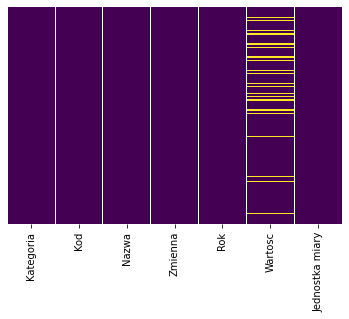

In [10]:
sns.heatmap(gminy_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
gminy_df.isnull().sum()

Kategoria               0
Kod                     0
Nazwa                   0
Zmienna                 0
Rok                     0
Wartosc            278967
Jednostka miary         0
dtype: int64

Widzimy, że wartości NaN występują tylko w kolumnie "Wartosc".

### Podział ramki danych wzgl. kolumny "Kategoria"

In [12]:
gminy_kategorie = gminy_df['Kategoria'].unique()
gminy = {}
for kategoria in gminy_kategorie:
    gminy[kategoria] = gminy_df[gminy_df['Kategoria']==kategoria]

In [13]:
print('Liczba ramek danych, na które został podzielony plik Gminy: ', len(gminy))
list(gminy.keys())

Liczba ramek danych, na które został podzielony plik Gminy:  8


['Ludność',
 'Ludność wg grup wieku',
 'Mężczyźni wg grup wieku',
 'Kobiety wg grup wieku',
 'Bezrobocie',
 'Skolaryzacja',
 'Dochody per capita',
 'Wydatki per capita']

In [14]:
for df in gminy:
    print('Kategoria: ', df)
    print('Liczba wszystkich wierszy w kolumnie Wartosc: ', gminy[df]['Wartosc'].count())
    print('Wartosci NaN w kolumnie "wartosci": ', gminy[df]['Wartosc'].isnull().sum())
    print('Procent wartości NaN w kolumnie Wartosc: ',  gminy[df]['Wartosc'].isnull().sum()/gminy[df]['Wartosc'].count()*100 ,' %')
    print("\n")

Kategoria:  Ludność
Liczba wszystkich wierszy w kolumnie Wartosc:  311216
Wartosci NaN w kolumnie "wartosci":  11708
Procent wartości NaN w kolumnie Wartosc:  3.7620173769986116  %


Kategoria:  Ludność wg grup wieku
Liczba wszystkich wierszy w kolumnie Wartosc:  238232
Wartosci NaN w kolumnie "wartosci":  67408
Procent wartości NaN w kolumnie Wartosc:  28.295107290372414  %


Kategoria:  Mężczyźni wg grup wieku
Liczba wszystkich wierszy w kolumnie Wartosc:  238232
Wartosci NaN w kolumnie "wartosci":  67408
Procent wartości NaN w kolumnie Wartosc:  28.295107290372414  %


Kategoria:  Kobiety wg grup wieku
Liczba wszystkich wierszy w kolumnie Wartosc:  238232
Wartosci NaN w kolumnie "wartosci":  67408
Procent wartości NaN w kolumnie Wartosc:  28.295107290372414  %


Kategoria:  Bezrobocie
Liczba wszystkich wierszy w kolumnie Wartosc:  220305
Wartosci NaN w kolumnie "wartosci":  7953
Procent wartości NaN w kolumnie Wartosc:  3.6099952338803023  %


Kategoria:  Skolaryzacja
Liczba wszystk

Tutaj mamy obraz tego czym warto / nie warto zajmować się w analizach. <br>
Jeśli zbyt duży procent danych jest nieznany, można wówczas do błędnych wniosków dojść.

### Wartości podejrzane
Kategoria: **Ludność**

Spodziewamy się, że 3 pierwsze "zmienne" będą wartościami dodatnimi

In [15]:
print(list(gminy['Ludność']['Zmienna'].unique()))
gminy['Ludność'][(gminy['Ludność']['Wartosc']<=0) & (gminy['Ludność']['Zmienna']!='przyrost naturalny na 1000 ludności')]

['ludność na 1 km2', 'urodzenia żywe na 1000 ludności', 'zgony na 1000 ludności', 'przyrost naturalny na 1000 ludności']


Kategoria      Kod                             Nazwa  \
39258     Ludność  1465028            Bemowo - dzielnica (8)   
39259     Ludność  1465028            Bemowo - dzielnica (8)   
39277     Ludność  1465038         Białołęka - dzielnica (8)   
39278     Ludność  1465038         Białołęka - dzielnica (8)   
39296     Ludność  1465048           Bielany - dzielnica (8)   
39297     Ludność  1465048           Bielany - dzielnica (8)   
39315     Ludność  1465058           Mokotów - dzielnica (8)   
39316     Ludność  1465058           Mokotów - dzielnica (8)   
39334     Ludność  1465068            Ochota - dzielnica (8)   
39335     Ludność  1465068            Ochota - dzielnica (8)   
39353     Ludność  1465078    Praga-Południe - dzielnica (8)   
39354     Ludność  1465078    Praga-Południe - dzielnica (8)   
39372     Ludność  1465088      Praga-Północ - dzielnica (8)   
39373     Ludność  1465088      Praga-Północ - dzielnica (8)   
39391     Ludność  1465098         Rembertów - dzielnica (8)   
39392     Ludność  1465098         Rembertów - dzielnica (8)   
39410     Ludność  1465108       Śródmieście - dzielnica (8)   
39411     Ludność  1465108       Śródmieście - dzielnica (8)   
39429     Ludność  1465118          Targówek - dzielnica (8)   
39430     Ludność  1465118          Targówek - dzielnica (8)   
39448     Ludność  1465128             Ursus - dzielnica (8)   
39449     Ludność  1465128             Ursus - dzielnica (8)   
39467     Ludność  1465138           Ursynów - dzielnica (8)   
39468     Ludność  1465138           Ursynów - dzielnica (8)   
39486     Ludność  1465148             Wawer - dzielnica (8)   
39487     Ludność  1465148             Wawer - dzielnica (8)   
39505     Ludność  1465158            Wesoła - dzielnica (8)   
39506     Ludność  1465158            Wesoła - dzielnica (8)   
39524     Ludność  1465168           Wilanów - dzielnica (8)   
39525     Ludność  1465168           Wilanów - dzielnica (8)   
39543     Ludność  1465178            Włochy - dzielnica (8)   
39544     Ludność  1465178            Włochy - dzielnica (8)   
39562     Ludność  1465188              Wola - dzielnica (8)   
39563     Ludność  1465188              Wola - dzielnica (8)   
39581     Ludność  1465198          Żoliborz - dzielnica (8)   
39582     Ludność  1465198          Żoliborz - dzielnica (8)   
1095602   Ludność  1411052                      Młynarze (2)   
1148206   Ludność  2011045       Krynki - obszar wiejski (5)   
1178701   Ludność  2603044            Opatowiec - miasto (4)   
1234462   Ludność  3211035  Nowe Warpno - obszar wiejski (5)   

                                 Zmienna   Rok  Wartosc Jednostka miary  
39258                   ludność na 1 km2  2006      0.0           osoba  
39259                   ludność na 1 km2  2007      0.0           osoba  
39277                   ludność na 1 km2  2006      0.0           osoba  
39278                   ludność na 1 km2  2007      0.0           osoba  
39296                   ludność na 1 km2  2006      0.0           osoba  
39297                   ludność na 1 km2  2007      0.0           osoba  
39315                   ludność na 1 km2  2006      0.0           osoba  
39316                   ludność na 1 km2  2007      0.0           osoba  
39334                   ludność na 1 km2  2006      0.0           osoba  
39335                   ludność na 1 km2  2007      0.0           osoba  
39353                   ludność na 1 km2  2006      0.0           osoba  
39354                   ludność na 1 km2  2007      0.0           osoba  
39372                   ludność na 1 km2  2006      0.0           osoba  
39373                   ludność na 1 km2  2007      0.0           osoba  
39391                   ludność na 1 km2  2006      0.0           osoba  
39392                   ludność na 1 km2  2007      0.0           osoba  
39410                   ludność na 1 km2  2006      0.0           osoba  
39411                   ludność na 1 km2  2007     

Kategoria: **Ludność wg grup wieku**

In [16]:
print(list(gminy['Ludność wg grup wieku']['Zmienna'].unique()))
gminy['Ludność wg grup wieku'].head()

['ogółem', '0-14', '15-64', '65 i więcej']


Kategoria  Kod   Nazwa Zmienna   Rok     Wartosc  \
80731  Ludność wg grup wieku    0  POLSKA  ogółem  2003  38190608.0   
80732  Ludność wg grup wieku    0  POLSKA  ogółem  2004  38173835.0   
80733  Ludność wg grup wieku    0  POLSKA  ogółem  2005  38157055.0   
80734  Ludność wg grup wieku    0  POLSKA  ogółem  2006  38125479.0   
80735  Ludność wg grup wieku    0  POLSKA  ogółem  2007  38115641.0   

      Jednostka miary  
80731           osoba  
80732           osoba  
80733           osoba  
80734           osoba  
80735           osoba

Spodziewamy się, że wartość powinna być liczbą naturalną.

In [17]:
df = gminy['Ludność wg grup wieku'][(gminy['Ludność wg grup wieku']['Wartosc']%1!=0) | (gminy['Ludność wg grup wieku']['Wartosc']<=0)]
df[~df['Wartosc'].isnull()]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Mężczyźni wg grup wieku**

In [18]:
print(list(gminy['Mężczyźni wg grup wieku']['Zmienna'].unique()))
gminy['Mężczyźni wg grup wieku'].head()

['ogółem', '0-14', '15-64', '65 i więcej']


Kategoria  Kod   Nazwa Zmienna   Rok     Wartosc  \
386371  Mężczyźni wg grup wieku    0  POLSKA  ogółem  2003  18486430.0   
386372  Mężczyźni wg grup wieku    0  POLSKA  ogółem  2004  18470253.0   
386373  Mężczyźni wg grup wieku    0  POLSKA  ogółem  2005  18453855.0   
386374  Mężczyźni wg grup wieku    0  POLSKA  ogółem  2006  18426775.0   
386375  Mężczyźni wg grup wieku    0  POLSKA  ogółem  2007  18411501.0   

       Jednostka miary  
386371           osoba  
386372           osoba  
386373           osoba  
386374           osoba  
386375           osoba

Spodziewamy się, że wartość powinna być liczbą naturalną.

In [19]:
df = gminy['Mężczyźni wg grup wieku'][(gminy['Mężczyźni wg grup wieku']['Wartosc']%1!=0) | (gminy['Mężczyźni wg grup wieku']['Wartosc']<=0)]
df[~df['Wartosc'].isnull()]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Kobiety wg grup wieku**

In [20]:
print(list(gminy['Kobiety wg grup wieku']['Zmienna'].unique()))
gminy['Kobiety wg grup wieku'].head().head()

['ogółem', '0-14', '15-64', '65 i więcej']


Kategoria  Kod   Nazwa Zmienna   Rok     Wartosc  \
692011  Kobiety wg grup wieku    0  POLSKA  ogółem  2003  19704178.0   
692012  Kobiety wg grup wieku    0  POLSKA  ogółem  2004  19703582.0   
692013  Kobiety wg grup wieku    0  POLSKA  ogółem  2005  19703200.0   
692014  Kobiety wg grup wieku    0  POLSKA  ogółem  2006  19698704.0   
692015  Kobiety wg grup wieku    0  POLSKA  ogółem  2007  19704140.0   

       Jednostka miary  
692011           osoba  
692012           osoba  
692013           osoba  
692014           osoba  
692015           osoba

Spodziewamy się, że wartość powinna być liczbą naturalną.

In [21]:
df = gminy['Kobiety wg grup wieku'][(gminy['Kobiety wg grup wieku']['Wartosc']%1!=0) | (gminy['Kobiety wg grup wieku']['Wartosc']<=0)]
df[~df['Wartosc'].isnull()]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Bezrobocie**

In [22]:
print(list(gminy['Bezrobocie']['Zmienna'].unique()))
gminy['Bezrobocie'].head()

['ogółem', 'mężczyźni', 'kobiety']


Kategoria  Kod   Nazwa Zmienna   Rok  Wartosc Jednostka miary
1239844  Bezrobocie    0  POLSKA  ogółem  2003     13.2               %
1239845  Bezrobocie    0  POLSKA  ogółem  2004     12.4               %
1239846  Bezrobocie    0  POLSKA  ogółem  2005     11.4               %
1239847  Bezrobocie    0  POLSKA  ogółem  2006      9.4               %
1239848  Bezrobocie    0  POLSKA  ogółem  2007      7.1               %

Spodziewamy się, że bezrobocie nie będzie miało wartości procentów ujemnych.

In [23]:
gminy['Bezrobocie'][gminy['Bezrobocie']['Wartosc']<0]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Skolaryzacja**

**Wskaźnik skolaryzacji** – jeden z dwóch podstawowych wskaźników stosowanych do badania poziomu edukacji. Stopa skolaryzacji to odsetek osób uczących się obliczany w stosunku do liczby ludności w określonym przedziale wiekowym, według podziału na odpowiednie etapy kształcenia:
- 7–15 lat – szkoła podstawowa
- 15–19 lat – szkoła średnia, zawodowa
- 19–24 – szkoła wyższa.

Wskaźnik ten najwyższy jest w szkołach podstawowych i wynosi prawie 100%, w miarę przechodzenia do następnych szkół maleje.

In [24]:
print(list(gminy['Skolaryzacja']['Zmienna'].unique()))
gminy['Skolaryzacja'].head()

['szkoły podstawowe', 'gimnazja']


Kategoria  Kod   Nazwa            Zmienna   Rok  Wartosc  \
1468102  Skolaryzacja    0  POLSKA  szkoły podstawowe  2003    98.48   
1468103  Skolaryzacja    0  POLSKA  szkoły podstawowe  2004    98.40   
1468104  Skolaryzacja    0  POLSKA  szkoły podstawowe  2005    98.13   
1468105  Skolaryzacja    0  POLSKA  szkoły podstawowe  2006    97.58   
1468106  Skolaryzacja    0  POLSKA  szkoły podstawowe  2007    96.78   

        Jednostka miary  
1468102               %  
1468103               %  
1468104               %  
1468105               %  
1468106               %

Spodziewamy się, że wskaźnik skolaryzacji nie będzie miał wartości ujemnych

In [25]:
gminy['Skolaryzacja'][gminy['Skolaryzacja']['Wartosc']<0]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

A czy może być większy niż 100%? **TAK**<br>
- Jeśli mamy wartość mniejszą niż 100%, to znaczy, że na terenie danej gminy uczy się mniej dzieci niż to wynika z ich populacji (powinno chodzić 100%). 
- Jeśli mamy więcej niż 100%, to znaczy, że albo dzieci dojeżdżają z sąsiednich gmin (najczęściej), albo repetują lata.

In [26]:
gminy['Skolaryzacja'][gminy['Skolaryzacja']['Wartosc']>100]

Kategoria      Kod            Nazwa            Zmienna   Rok  \
1468210  Skolaryzacja   201011  Bolesławiec (1)  szkoły podstawowe  2003   
1468211  Skolaryzacja   201011  Bolesławiec (1)  szkoły podstawowe  2004   
1468212  Skolaryzacja   201011  Bolesławiec (1)  szkoły podstawowe  2005   
1468213  Skolaryzacja   201011  Bolesławiec (1)  szkoły podstawowe  2006   
1468214  Skolaryzacja   201011  Bolesławiec (1)  szkoły podstawowe  2007   
...               ...      ...              ...                ...   ...   
1620133  Skolaryzacja  3262011     Szczecin (1)  szkoły podstawowe  2006   
1620134  Skolaryzacja  3262011     Szczecin (1)  szkoły podstawowe  2007   
1620147  Skolaryzacja  3262011     Szczecin (1)  szkoły podstawowe  2020   
1620151  Skolaryzacja  3262011     Szczecin (1)           gimnazja  2006   
1620152  Skolaryzacja  3262011     Szczecin (1)           gimnazja  2007   

         Wartosc Jednostka miary  
1468210   103.08               %  
1468211   102.29               %  
1468212   101.23               %  
1468213   102.47               %  
1468214   100.68               %  
...          ...             ...  
1620133   101.50               %  
1620134   100.33               %  
1620147   101.78               %  
1620151   100.18               %  
1620152   100.16               %  

[35025 rows x 7 columns]

Kategoria: **Dochody per capita** <br>

Dochód per capita (na głowę) jest sumą dochodu podzieloną przez wielkość populacji.

In [27]:
print(list(gminy['Dochody per capita']['Zmienna'].unique()))
gminy['Dochody per capita'].head()

['ogółem']


Kategoria  Kod   Nazwa Zmienna   Rok  Wartosc  \
1620238  Dochody per capita    0  POLSKA  ogółem  2002  1663.00   
1620239  Dochody per capita    0  POLSKA  ogółem  2003  1662.00   
1620240  Dochody per capita    0  POLSKA  ogółem  2004  1887.00   
1620241  Dochody per capita    0  POLSKA  ogółem  2005  2151.00   
1620242  Dochody per capita    0  POLSKA  ogółem  2006  2431.28   

        Jednostka miary  
1620238              zł  
1620239              zł  
1620240              zł  
1620241              zł  
1620242              zł

Spodziewamy się, że wartość dochodu per capita nie będzie ujemna.

In [28]:
gminy['Dochody per capita'][gminy['Dochody per capita']['Wartosc']<0]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Wydatki per capita**

In [29]:
print(list(gminy['Wydatki per capita']['Zmienna'].unique()))
gminy['Wydatki per capita'].head()

['ogółem', 'w Dziale 801- Oświata i wychowanie', 'w Dziale 921 - Kultura i ochrona dziedzictwa narodowego', 'wydatki w rozdziale 90005 Ochrona powietrza atmosferycznego i klimatu', 'wydatki majątkowe']


Kategoria  Kod   Nazwa Zmienna   Rok  Wartosc  \
1676231  Wydatki per capita    0  POLSKA  ogółem  2001      NaN   
1676232  Wydatki per capita    0  POLSKA  ogółem  2002   1731.0   
1676233  Wydatki per capita    0  POLSKA  ogółem  2003   1696.0   
1676234  Wydatki per capita    0  POLSKA  ogółem  2004   1914.0   
1676235  Wydatki per capita    0  POLSKA  ogółem  2005   2157.0   

        Jednostka miary  
1676231              zł  
1676232              zł  
1676233              zł  
1676234              zł  
1676235              zł

Spodziewamy się, że wartość wydatków per capita nie będzie ujemna.

In [30]:
gminy['Wydatki per capita'][gminy['Wydatki per capita']['Wartosc']<0]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

## 3.2. Plik ludnosc.csv
- patrzymy na unikalne wartości kolumny 'Kategoria'
- używamy metody pivot_table() dla lepszego zobrazowania powiązań kolumn "Kategoria" i "Zmienna"

In [31]:
print(list(ludnosc_df['Kategoria'].unique()))
pd.pivot_table(ludnosc_df,index=['Kategoria','Zmienna'])

['Gospodarstwa', 'Osoby', 'Wyposażenie', 'Artykuły', 'Dochody', 'Wydatki']


Kod  \
Kategoria   Zmienna                                                       
Artykuły    cukier                                              1600000   
            jaja                                                1600000   
            jogurty                                             1600000   
            jogurty i napoje mleczne                            1600000   
            mięso                                               1600000   
...                                                                 ...   
Wyposażenie urządzenie do odbioru telewizji satelitarnej lu...  1600000   
            urządzenie z dostępem do Internetu                  1600000   
            zestaw do odbioru, rejestracji i odtwarzania dź...  1600000   
            zestaw kina domowego                                1600000   
            zmywarka do naczyń                                  1600000   

                                                                   Rok  \
Kategoria   Zmienna                                                      
Artykuły    cukier                                              2011.5   
            jaja                                                2011.5   
            jogurty                                             2011.5   
            jogurty i napoje mleczne                            2011.5   
            mięso                                               2011.5   
...                                                                ...   
Wyposażenie urządzenie do odbioru telewizji satelitarnej lu...  2011.5   
            urządzenie z dostępem do Internetu                  2011.5   
            zestaw do odbioru, rejestracji i odtwarzania dź...  2011.5   
            zestaw kina domowego                                2011.5   
            zmywarka do naczyń                                  2011.5   

                                                                  Wartosc  
Kategoria   Zmienna                                                        
Artykuły    cukier                                               1.247614  
            jaja                                                12.861471  
            jogurty                                              0.524926  
            jogurty i napoje mleczne                             0.724338  
            mięso                                                5.479673  
...                                                                   ...  
Wyposażenie urządzenie do odbioru telewizji satelitarnej lu...  62.687843  
            urządzenie z dostępem do Internetu                  79.723529  
            zestaw do odbioru, rejestracji i odtwarzania dź...  42.674790  
            zestaw kina domowego                                12.860963  
            zmywarka do naczyń                                  19.245098  

[76 rows x 3 columns]

### Braki danych

Zobrazujmy wpierw braki danych za pomocą heatmap'y z biblioteki seaborn, a następnie policzmy ile ich jest:

<AxesSubplot:>

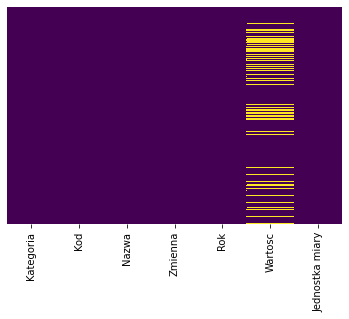

In [32]:
sns.heatmap(ludnosc_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [33]:
ludnosc_df.isnull().sum()

Kategoria             0
Kod                   0
Nazwa                 0
Zmienna               0
Rok                   0
Wartosc            6732
Jednostka miary       0
dtype: int64

Podobnie jak w pliku gminy.csv - wartości NaN występują tylko w kolumnie "Wartosc".

### Podział ramki danych wzgl. kolumny "Kategoria"

In [34]:
ludnosc_kategorie = ludnosc_df['Kategoria'].unique()

ludnosc = {}

for kategoria in ludnosc_kategorie:
    ludnosc[kategoria] = ludnosc_df[ludnosc_df['Kategoria']==kategoria]

In [35]:
print('Liczba ramek danych, na które został podzielony plik Ludność: ', len(ludnosc))
list(ludnosc.keys())

Liczba ramek danych, na które został podzielony plik Ludność:  6


['Gospodarstwa', 'Osoby', 'Wyposażenie', 'Artykuły', 'Dochody', 'Wydatki']

In [36]:
for df in ludnosc:
    print('Kategoria: ', df)
    print('Liczba wszystkich wierszy w kolumnie Wartosc: ', ludnosc[df]['Wartosc'].count())
    print('Wartosci NaN w kolumnie "wartosci": ', ludnosc[df]['Wartosc'].isnull().sum())
    print('Procent wartości NaN w kolumnie Wartosc: ',  ludnosc[df]['Wartosc'].isnull().sum()/ludnosc[df]['Wartosc'].count()*100 ,' %')
    print("\n")

Kategoria:  Gospodarstwa
Liczba wszystkich wierszy w kolumnie Wartosc:  374
Wartosci NaN w kolumnie "wartosci":  0
Procent wartości NaN w kolumnie Wartosc:  0.0  %


Kategoria:  Osoby
Liczba wszystkich wierszy w kolumnie Wartosc:  2074
Wartosci NaN w kolumnie "wartosci":  170
Procent wartości NaN w kolumnie Wartosc:  8.19672131147541  %


Kategoria:  Wyposażenie
Liczba wszystkich wierszy w kolumnie Wartosc:  3927
Wartosci NaN w kolumnie "wartosci":  2805
Procent wartości NaN w kolumnie Wartosc:  71.42857142857143  %


Kategoria:  Artykuły
Liczba wszystkich wierszy w kolumnie Wartosc:  3944
Wartosci NaN w kolumnie "wartosci":  2176
Procent wartości NaN w kolumnie Wartosc:  55.172413793103445  %


Kategoria:  Dochody
Liczba wszystkich wierszy w kolumnie Wartosc:  2907
Wartosci NaN w kolumnie "wartosci":  459
Procent wartości NaN w kolumnie Wartosc:  15.789473684210526  %


Kategoria:  Wydatki
Liczba wszystkich wierszy w kolumnie Wartosc:  5916
Wartosci NaN w kolumnie "wartosci":  1122
Pr

### Wartości podejrzane

Kategoria: **Gospodarstwa**

In [37]:
print(list(ludnosc['Gospodarstwa']['Zmienna'].unique()))
ludnosc['Gospodarstwa'].head()

['gospodarstwa domowe objęte badaniem']


Kategoria  Kod   Nazwa                              Zmienna   Rok  \
0  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  1999   
1  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2000   
2  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2001   
3  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2002   
4  Gospodarstwa    0  POLSKA  gospodarstwa domowe objęte badaniem  2003   

   Wartosc Jednostka miary  
0  31428.0           gosp.  
1  36163.0           gosp.  
2  31847.0           gosp.  
3  32342.0           gosp.  
4  32452.0           gosp.

Spodziewamy się, że Wartosc >= 0.

In [38]:
ludnosc['Gospodarstwa'][ludnosc['Gospodarstwa']['Wartosc']<0]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Osoby**

In [39]:
list(ludnosc['Osoby']['Zmienna'].unique())

['ogółem',
 'pracujących',
 'pobierający świadczenia społeczne',
 'emerytury i renty',
 'pozostających na utrzymaniu',
 'przeciętna liczba osób pobierających  świadczenia społeczne w relacji do przeciętnej liczby osób w gospodarstwie domowym']

In [40]:
ludnosc['Osoby'][ludnosc['Osoby']['Zmienna']=='pracujących']

Kategoria      Kod               Nazwa      Zmienna   Rok  Wartosc  \
396      Osoby        0              POLSKA  pracujących  1999     1.12   
397      Osoby        0              POLSKA  pracujących  2000     1.09   
398      Osoby        0              POLSKA  pracujących  2001     1.06   
399      Osoby        0              POLSKA  pracujących  2002     1.03   
400      Osoby        0              POLSKA  pracujących  2003     1.04   
...        ...      ...                 ...          ...   ...      ...   
2525     Osoby  3200000  ZACHODNIOPOMORSKIE  pracujących  2016     1.03   
2526     Osoby  3200000  ZACHODNIOPOMORSKIE  pracujących  2017     1.00   
2527     Osoby  3200000  ZACHODNIOPOMORSKIE  pracujących  2018     0.93   
2528     Osoby  3200000  ZACHODNIOPOMORSKIE  pracujących  2019     0.93   
2529     Osoby  3200000  ZACHODNIOPOMORSKIE  pracujących  2020     0.88   

     Jednostka miary  
396            osoba  
397            osoba  
398            osoba  
399            osoba  
400            osoba  
...              ...  
2525           osoba  
2526           osoba  
2527           osoba  
2528           osoba  
2529           osoba  

[374 rows x 7 columns]

Czemu są osoby w ułamkach??? Trzeba zidentyfikować intencję wartości

Kategoria: **Wyposażenie**

In [41]:
list(ludnosc['Wyposażenie']['Zmienna'].unique())
ludnosc['Wyposażenie'].head()

Kategoria  Kod   Nazwa      Zmienna   Rok  Wartosc Jednostka miary
2618  Wyposażenie    0  POLSKA  chłodziarka  2003     97.5               %
2619  Wyposażenie    0  POLSKA  chłodziarka  2004     97.7               %
2620  Wyposażenie    0  POLSKA  chłodziarka  2005     97.3               %
2621  Wyposażenie    0  POLSKA  chłodziarka  2006      NaN               %
2622  Wyposażenie    0  POLSKA  chłodziarka  2007      NaN               %

Spodziewamy się, że wartość nieujemna i nie większa niż 100.

In [42]:
ludnosc['Wyposażenie'][(ludnosc['Wyposażenie']['Wartosc']<0) | (ludnosc['Wyposażenie']['Wartosc']>100)]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Artykuły**

In [43]:
print(list(ludnosc['Artykuły']['Zmienna'].unique()))
ludnosc['Artykuły'].head()

['pieczywo i produkty zbożowe', 'pieczywo', 'mięso', 'mięso surowe', 'mięso surowe drobiowe', 'wędliny i inne przetwory mięsne', 'wędliny', 'ryby', 'ryby i owoce morza', 'mleko świeże', 'jogurty i napoje mleczne', 'jogurty', 'mleko (bez zagęszczonego i w proszku), napoje mleczne i jogurty', 'sery i twarogi', 'jaja', 'oleje i tłuszcze', 'owoce', 'warzywa', 'ziemniaki', 'cukier']


Kategoria  Kod   Nazwa                      Zmienna   Rok  Wartosc  \
9350  Artykuły    0  POLSKA  pieczywo i produkty zbożowe  2003     8.82   
9351  Artykuły    0  POLSKA  pieczywo i produkty zbożowe  2004     8.68   
9352  Artykuły    0  POLSKA  pieczywo i produkty zbożowe  2005     8.44   
9353  Artykuły    0  POLSKA  pieczywo i produkty zbożowe  2006     8.05   
9354  Artykuły    0  POLSKA  pieczywo i produkty zbożowe  2007     7.70   

     Jednostka miary  
9350              kg  
9351              kg  
9352              kg  
9353              kg  
9354              kg

Spodziewamy się, że artykuły nie będą posiadały wartości (ilości/wagi/liczby) ujemnych.

In [44]:
ludnosc['Artykuły'][ludnosc['Artykuły']['Wartosc']<0]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

Kategoria: **Dochody**

In [45]:
print(list(ludnosc['Dochody']['Zmienna'].unique()))
ludnosc['Dochody'].head()

['ogółem', 'z pracy najemnej', 'z gospodarstwa indywidualnego w rolnictwie', 'z pracy na własny rachunek', 'przeciętny miesięczny dochód rozporządzalny na 1 osobę  z gospodarstwa indywidualnego w rolnictwie w relacji do przeciętnego miesięcznego dochodu na 1 osobę z pracy na własny rachunek', 'ze świadczeń społecznych', 'ze świadczeń społecznych; w tym ze świadczenia wychowawczego Rodzina 500+""', 'dochód do dyspozycji', 'ogółem, Polska = 100']


Kategoria  Kod   Nazwa Zmienna   Rok  Wartosc Jednostka miary
15470   Dochody    0  POLSKA  ogółem  1999   560.43              zł
15471   Dochody    0  POLSKA  ogółem  2000   610.51              zł
15472   Dochody    0  POLSKA  ogółem  2001   644.48              zł
15473   Dochody    0  POLSKA  ogółem  2002   664.21              zł
15474   Dochody    0  POLSKA  ogółem  2003   711.96              zł

Spodziewamy się, że dochody są nieujemne.

In [46]:
ludnosc['Dochody'][ludnosc['Dochody']['Wartosc']<0]

Kategoria      Kod         Nazwa  \
15727   Dochody   200000  DOLNOŚLĄSKIE   
15771   Dochody   200000  DOLNOŚLĄSKIE   
16311   Dochody   800000      LUBUSKIE   
16312   Dochody   800000      LUBUSKIE   
16355   Dochody   800000      LUBUSKIE   
16356   Dochody   800000      LUBUSKIE   
17098   Dochody  1600000      OPOLSKIE   
17114   Dochody  1600000      OPOLSKIE   
17115   Dochody  1600000      OPOLSKIE   
17158   Dochody  1600000      OPOLSKIE   
17159   Dochody  1600000      OPOLSKIE   

                                                 Zmienna   Rok  Wartosc  \
15727         z gospodarstwa indywidualnego w rolnictwie  2014    -0.97   
15771  przeciętny miesięczny dochód rozporządzalny na...  2014    -0.90   
16311         z gospodarstwa indywidualnego w rolnictwie  2004    -9.30   
16312         z gospodarstwa indywidualnego w rolnictwie  2005   -20.85   
16355  przeciętny miesięczny dochód rozporządzalny na...  2004   -17.30   
16356  przeciętny miesięczny dochód rozporządzalny na...  2005   -31.80   
17098         z gospodarstwa indywidualnego w rolnictwie  1999    -6.69   
17114         z gospodarstwa indywidualnego w rolnictwie  2015    -2.28   
17115         z gospodarstwa indywidualnego w rolnictwie  2016   -13.62   
17158  przeciętny miesięczny dochód rozporządzalny na...  2015    -2.80   
17159  przeciętny miesięczny dochód rozporządzalny na...  2016   -15.20   

      Jednostka miary  
15727              zł  
15771               %  
16311              zł  
16312              zł  
16355               %  
16356               %  
17098              zł  
17114              zł  
17115              zł  
17158               %  
17159               %

In [47]:
ludnosc['Dochody'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 15470 to 18835
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Kategoria        3366 non-null   string 
 1   Kod              3366 non-null   int32  
 2   Nazwa            3366 non-null   string 
 3   Zmienna          3366 non-null   string 
 4   Rok              3366 non-null   int32  
 5   Wartosc          2907 non-null   float64
 6   Jednostka miary  3366 non-null   string 
dtypes: float64(1), int32(2), string(4)
memory usage: 184.1 KB


In [48]:
ludnosc['Dochody'][ludnosc['Dochody']['Wartosc']<0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 15727 to 17159
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Kategoria        11 non-null     string 
 1   Kod              11 non-null     int32  
 2   Nazwa            11 non-null     string 
 3   Zmienna          11 non-null     string 
 4   Rok              11 non-null     int32  
 5   Wartosc          11 non-null     float64
 6   Jednostka miary  11 non-null     string 
dtypes: float64(1), int32(2), string(4)
memory usage: 616.0 bytes


Do wyrzucenia tych 11 rekordów?

Kategoria: **Wydatki**

In [49]:
print(list(ludnosc['Wydatki']['Zmienna'].unique()))
ludnosc['Wydatki'].head()

['ogółem', 'towary i usługi konsumpcyjne', 'żywność i napoje bezalkoholowe', 'napoje alkoholowe i wyroby tytoniowe', 'odzież i obuwie', 'użytkowanie mieszkania lub domu i nośniki energii', 'wyposażenie mieszkania i prowadzenie gospodarstwa domowego', 'zdrowie', 'transport', 'łączność', 'rekreacja i kultura', 'edukacja', 'restauracje i hotele', 'pozostałe wydatki na towary i usługi', 'ogółem (BAEL)', 'towary i usługi konsumpcyjne (BAEL)', 'udział wydatków na żywność i napoje bezalkoholowe w wydatkach ogółem', 'udział wydatków na użytkowanie mieszkania i nośniki energii w wydatkach ogółem']


Kategoria  Kod   Nazwa Zmienna   Rok  Wartosc Jednostka miary
18836   Wydatki    0  POLSKA  ogółem  1998   503.03              zł
18837   Wydatki    0  POLSKA  ogółem  1999   549.76              zł
18838   Wydatki    0  POLSKA  ogółem  2000   599.49              zł
18839   Wydatki    0  POLSKA  ogółem  2001   609.72              zł
18840   Wydatki    0  POLSKA  ogółem  2002   624.99              zł

Spodziewamy się, że wydatki będą nieujemne.

In [50]:
ludnosc['Wydatki'][ludnosc['Wydatki']['Wartosc']<0]

Empty DataFrame
Columns: [Kategoria, Kod, Nazwa, Zmienna, Rok, Wartosc, Jednostka miary]
Index: []

In [51]:
ludnosc['Wydatki'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7038 entries, 18836 to 25873
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Kategoria        7038 non-null   string 
 1   Kod              7038 non-null   int32  
 2   Nazwa            7038 non-null   string 
 3   Zmienna          7038 non-null   string 
 4   Rok              7038 non-null   int32  
 5   Wartosc          5916 non-null   float64
 6   Jednostka miary  7038 non-null   string 
dtypes: float64(1), int32(2), string(4)
memory usage: 384.9 KB


In [52]:
ludnosc['Wydatki'][ludnosc['Wydatki']['Wartosc']<0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Kategoria        0 non-null      string 
 1   Kod              0 non-null      int32  
 2   Nazwa            0 non-null      string 
 3   Zmienna          0 non-null      string 
 4   Rok              0 non-null      int32  
 5   Wartosc          0 non-null      float64
 6   Jednostka miary  0 non-null      string 
dtypes: float64(1), int32(2), string(4)
memory usage: 0.0 bytes


# 4. Analiza danych

Łączymy ze sobą dataframe **Gminy** i **TERC**, zawierający informacje na temat kodów terytorium.

In [54]:
terc_df.head()

TERYT  RODZ          NAZWA      NAZWA_DOD     STAN_NA
0  200000  <NA>   DOLNOŚLĄSKIE    województwo  01.01.2021
1  201000  <NA>  bolesławiecki         powiat  01.01.2021
2  201011     1    Bolesławiec  gmina miejska  01.01.2021
3  201022     2    Bolesławiec  gmina wiejska  01.01.2021
4  201032     2       Gromadka  gmina wiejska  01.01.2021

In [53]:
gminy_df = pd.merge(gminy_df, terc_df, how='left', left_on='Kod',right_on='TERYT')
gminy_df = gminy_df.drop(labels=['TERYT', 'STAN_NA'], axis=1)
gminy_df

Kategoria      Kod            Nazwa            Zmienna  \
0                   Ludność        0           POLSKA   ludność na 1 km2   
1                   Ludność        0           POLSKA   ludność na 1 km2   
2                   Ludność        0           POLSKA   ludność na 1 km2   
3                   Ludność        0           POLSKA   ludność na 1 km2   
4                   Ludność        0           POLSKA   ludność na 1 km2   
...                     ...      ...              ...                ...   
1971426  Wydatki per capita  3263011  Świnoujście (1)  wydatki majątkowe   
1971427  Wydatki per capita  3263011  Świnoujście (1)  wydatki majątkowe   
1971428  Wydatki per capita  3263011  Świnoujście (1)  wydatki majątkowe   
1971429  Wydatki per capita  3263011  Świnoujście (1)  wydatki majątkowe   
1971430  Wydatki per capita  3263011  Świnoujście (1)  wydatki majątkowe   

          Rok  Wartosc Jednostka miary  RODZ        NAZWA      NAZWA_DOD  
0        2002    122.0           osoba  <NA>          NaN            NaN  
1        2003    122.0           osoba  <NA>          NaN            NaN  
2        2004    122.0           osoba  <NA>          NaN            NaN  
3        2005    122.0           osoba  <NA>          NaN            NaN  
4        2006    122.0           osoba  <NA>          NaN            NaN  
...       ...      ...             ...   ...          ...            ...  
1971426  2016   1114.0              zł     1  Świnoujście  gmina miejska  
1971427  2017   1024.0              zł     1  Świnoujście  gmina miejska  
1971428  2018   3206.0              zł     1  Świnoujście  gmina miejska  
1971429  2019   5256.0              zł     1  Świnoujście  gmina miejska  
1971430  2020   9089.0              zł     1  Świnoujście  gmina miejska  

[1971431 rows x 10 columns]

# Przykładowe polecenie od Pani Dominiki: Analiza statystyczna średnich dochodów na głowę w gospodarstwach domowych w poszczególnych województwach w 2020 (przedział ufności uzyskany z rozkładu Studenta)

In [ ]:
dochody_df = ludnosc['Dochody'][(ludnosc['Dochody'].Rok == 2020)]
print(len(dochody_df))
dochody_df

153


Kategoria      Kod               Nazwa  ...   Rok  Wartosc  Jednostka miary
15491   Dochody        0              POLSKA  ...  2020  1919.21               zł
15513   Dochody        0              POLSKA  ...  2020  1017.33               zł
15535   Dochody        0              POLSKA  ...  2020    63.56               zł
15557   Dochody        0              POLSKA  ...  2020   173.94               zł
15579   Dochody        0              POLSKA  ...  2020    36.50                %
...         ...      ...                 ...  ...   ...      ...              ...
18747   Dochody  3200000  ZACHODNIOPOMORSKIE  ...  2020     6.00                %
18769   Dochody  3200000  ZACHODNIOPOMORSKIE  ...  2020   736.94               zł
18791   Dochody  3200000  ZACHODNIOPOMORSKIE  ...  2020   112.89               zł
18813   Dochody  3200000  ZACHODNIOPOMORSKIE  ...  2020  1813.33               zł
18835   Dochody  3200000  ZACHODNIOPOMORSKIE  ...  2020    97.00                %

[153 rows x 7 columns]

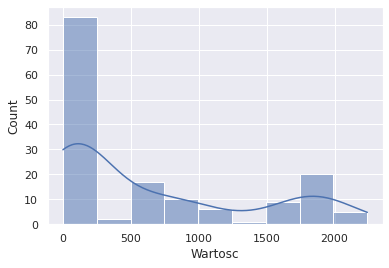

In [ ]:
# dochody_df['Wartosc'].plot(kind='hist')
sns.set_theme()
sns.histplot(data=dochody_df,x='Wartosc',kde=True)

## 4.1. Regresja liniowa

Pytania, które można postawić w kontekście regresji liniowej:

- <u>Pytanie 1</u>: Czy wydatki są liniowo skorelowane z dochodami?, Czy wydatki zależą od dochodów?
- <u>Pytanie 2</u>: Czy spożycie napojów alkoholowych i wyrobów tytoniowych zależy od pobierania świadczenia 500+?
- <u>Pytanie 3</u>: Czy wydatki na zdrowie będą zależeć od dochodów do dyspozycji?

### Wizualizacje danych na wykresie dot. powyższych pytań
<u> Pytanie 1.</u> Czy wydatki są liniowo skorelowane z dochodami? Czy wydatki zależą od dochodów?

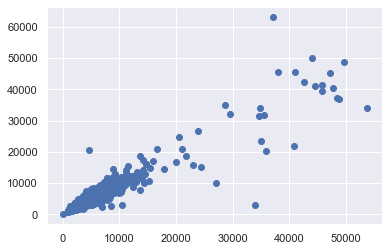

In [56]:
sns.set_theme()

#Łącze dwie tabele dot. wydatków i dochodów aby przeanalizować na wykresie
df_lregr = pd.merge(gminy['Dochody per capita'], gminy['Wydatki per capita'][gminy['Wydatki per capita'].Zmienna == 'ogółem'], how='left', on = ['Kod', 'Rok'])
#Wyrzucam NA (do zrobienia wyżej)
df_lregr = df_lregr.dropna()
#Wyrzucam kody z wartościami dla Polski i konkretnych województw
voiv_list = [0, 200000, 400000, 600000, 800000, 1000000, 1200000, 1400000, 1600000, 1800000, 2000000, 2200000, 2400000, 2600000, 2800000, 3000000, 3200000]
df_lregr = df_lregr[~df_lregr.Kod.isin(voiv_list)]
#Wykres punktowy dla powyższych danych
plt.scatter(df_lregr['Wartosc_x'], df_lregr['Wartosc_y'])
plt.show()

<u>Pytanie 2</u>: Czy spożycie napojów alkoholowych i wyrobów tytoniowych zależy od pobierania świadczenia 500+?

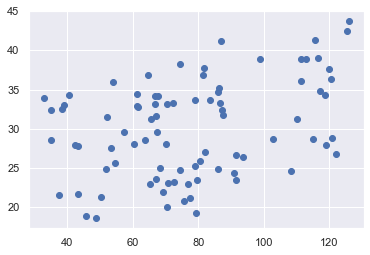

In [57]:
df_lud1 = pd.merge(ludnosc['Wydatki'][ludnosc['Wydatki'].Zmienna == 'napoje alkoholowe i wyroby tytoniowe'], ludnosc['Dochody'][ludnosc['Dochody'].Zmienna == 'ze świadczeń społecznych; w tym ze świadczenia wychowawczego Rodzina 500+""'], how='left', on = ['Kod', 'Rok'])
df_lud1 = df_lud1.dropna()
plt.scatter(df_lud1['Wartosc_y'], df_lud1['Wartosc_x'])
plt.show()

<u>Pytanie 3</u>: Czy wydatki na zdrowie będą zależeć od dochodów do dyspozycji?

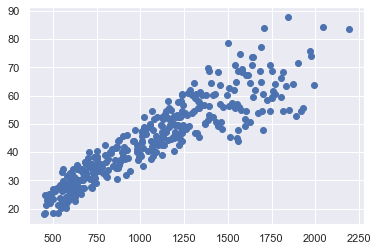

In [62]:
df_lud2 = pd.merge(ludnosc['Wydatki'][ludnosc['Wydatki'].Zmienna == 'zdrowie'], ludnosc['Dochody'][ludnosc['Dochody'].Zmienna == 'dochód do dyspozycji'], how='left', on = ['Kod', 'Rok'])
df_lud2 = df_lud2.dropna()
plt.scatter(df_lud2['Wartosc_y'], df_lud2['Wartosc_x'])
plt.show()

Najrozsądniej i najciekawiej brzmi pytanie trzecie, dla którego przeprowadzamy regresję liniową.


---


**Metoda 1**

- **y_lr** - zmienna objaśniana
- **x_lr** - wektor zmiennych objaśniających
- **f(x) = ax + b** - funkcja określająca model regresyjny
- **MSE** - błąd średniokwadratowy

In [63]:
#Ustalamy x i y dla naszej analizy
x_lr = df_lud2['Wartosc_x']
y_lr = df_lud2['Wartosc_y']
#Tworzymy model regresji liniowej oraz wyliczamy współczynniki a i b, r2 oraz błędy
lr_model = linregress(x_lr, y_lr)  
a = lr_model.slope  
b = lr_model.intercept  
corr_square = lr_model.rvalue ** 2
y_hat = x_lr * a + b  
mse = ((y_lr - y_hat) ** 2).sum() / len(x_lr)
print('Optimal model: f(x) = {:.6f}x {:+.6f}; MSE: {:.6f}; R2: {:.6f}'.format(a, b, mse, corr_square))
px.scatter(x = x_lr, y = y_lr, trendline='ols').show()

#Tutaj można przeprowadzić test t-studenta do weryfikacji czy chcemy to zrobić
#from scipy.stats import t
#tinv = lambda p, df: abs(t.ppf(p/2, df))
#ts = tinv(0.05, len(x_lr)-2)
#print(f"slope (95%): {lr_model.slope:.6f} +/- {ts*lr_model.stderr:.6f}")
#print("intercept (95%): {:.6f} +/- {:.6f}".format(lr_model.intercept, lr_model.intercept))

Optimal model: f(x) = 25.567760x -65.865629; MSE: 26912.918756; R2: 0.832331


**Metoda 2**

x1    5.249342e-114
dtype: float64
Root Mean Squared Error: 197.29880023410027


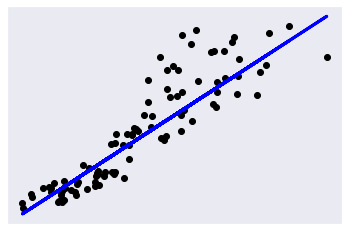

In [61]:
x_lr = df_lud2['Wartosc_x'].values.reshape(-1,1)

x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x_lr, y_lr, test_size = 0.25) 
model_linreg = LinearRegression()
model_linreg.fit(x_train_lr, y_train_lr)

x_lr = sm.add_constant(x_train_lr)
model_stat_lr = sm.OLS(y_train_lr,x_lr)
results_lr = model_stat_lr.fit()
#results_lr.params
p = results_lr.pvalues
print(p[p<=0.05])
y_pred = model_linreg.predict(x_test_lr)
df = pd.DataFrame({'Actual': y_test_lr, 'Predicted': y_pred})
df
print('Mean Squared Error:', metrics.mean_squared_error(y_test_lr, y_pred))
plt.scatter(x_test_lr, y_test_lr, color="black")
plt.plot(x_test_lr, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## 4.2. Drzewo decyzyjne

**DecisionTreeClassifier**(criterion="gini", ccp_alpha=)
- **criterion{"gini", "entropy"}** - funkcja pomiaru jakości podziału
- **ccp_alpha** - parametr do pruningu

<u>Propozycja drzewa 1</u>: Wydatki, Dochody -> Bezrobocie


In [71]:
df_dectree = pd.merge(gminy['Bezrobocie'][gminy['Bezrobocie'].Zmienna == 'ogółem'], gminy['Wydatki per capita'][gminy['Wydatki per capita'].Zmienna == 'ogółem'], how='left', on = ['Kod', 'Rok'])
df_dectree = df_dectree.rename({'Wartosc_x': 'Bezrobocie', 'Wartosc_y': 'Wydatki'}, axis=1)
df_dectree = pd.merge(df_dectree, gminy['Dochody per capita'][gminy['Dochody per capita'].Zmienna == 'ogółem'], how='left', on = ['Kod', 'Rok'])
df_dectree = pd.merge(df_dectree, gminy['Ludność'][gminy['Ludność'].Zmienna == 'przyrost naturalny na 1000 ludności'], how='left', on = ['Kod', 'Rok'])
df_dectree = df_dectree.rename({'Wartosc_x': 'Dochody', 'Wartosc_y': 'Przyrost naturalny'}, axis=1)
df_dectree = df_dectree.dropna()

df_dectree = df_dectree[['Kod', 'Bezrobocie', 'Wydatki', 'Dochody', 'Przyrost naturalny']]

def code(x):
  if x <= 9:
    return 'niski'
  else:
    return 'wysoki'

df_dectree['Bezrobocie'] = df_dectree['Bezrobocie'].apply(code)
df_dectree['Bezrobocie'] = df_dectree['Bezrobocie'].astype('string')
df_dectree = df_dectree[~df_dectree.Kod.isin(voiv_list)]
df_dectree = df_dectree.loc[:, ~df_dectree.columns.duplicated()]

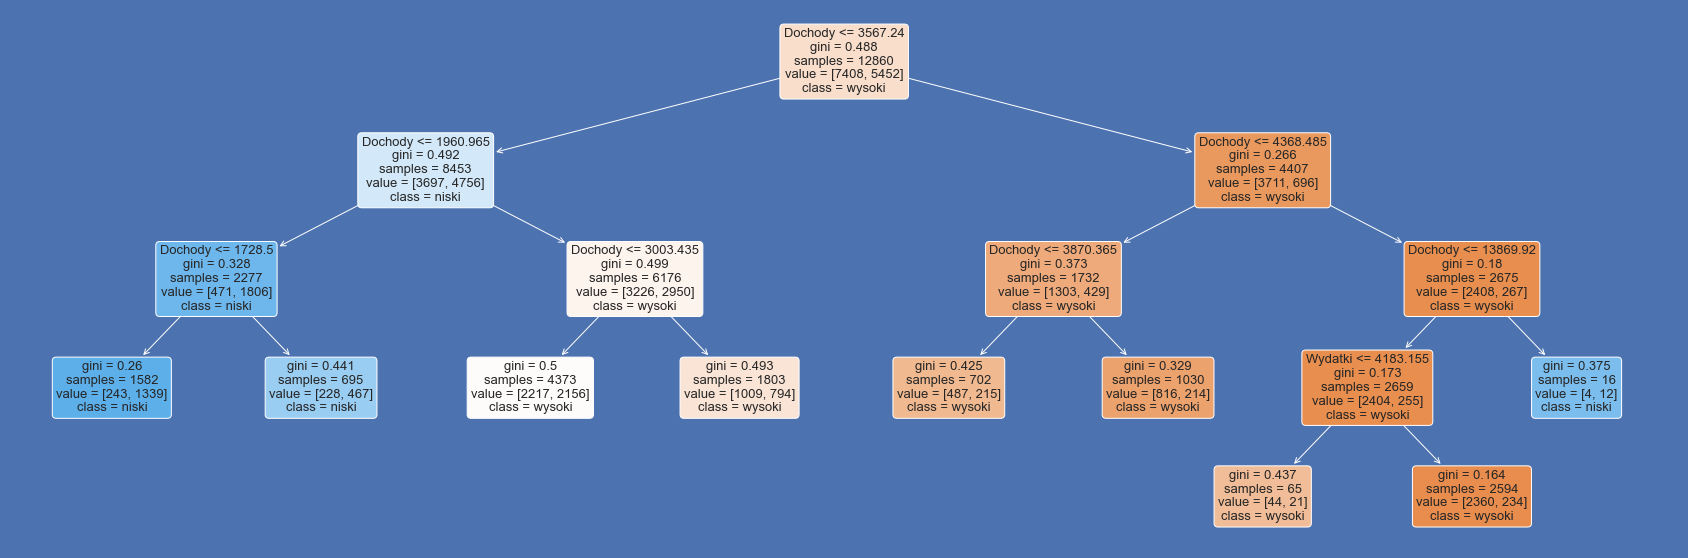

Dokładność: 0.6804821150855366


In [72]:
#Zmienne 
x_dclf = df_dectree[['Wydatki', 'Dochody']]
#Klasa
y_dclf = df_dectree['Bezrobocie']
#Podział zmiennych na zbiór testowy oraz treningowy
x_train_dclf, x_test_dclf, y_train_dclf, y_test_dclf = train_test_split(x_dclf, y_dclf, test_size = 0.25)
#Algorytm drzew decyzyjnych oraz pruning na podstawie algorytmu
dec_clf = DecisionTreeClassifier(criterion="gini", ccp_alpha=0.0004)
#Uczenie algorytmu
dec_clf = dec_clf.fit(x_test_dclf, y_test_dclf)
#Tworzenie predykcji
y_pred = dec_clf.predict(x_test_dclf)


#Wizualizacja danych
plt.figure(figsize=(30,10), facecolor ='b')
a = tree.plot_tree(dec_clf, feature_names = x_dclf.columns, class_names=y_dclf.unique(), rounded = True, filled = True, fontsize=13)
plt.show()
#Dokładność danych:
print("Dokładność:",metrics.accuracy_score(y_test_dclf, y_pred))

Wizualizacja dokładności predykcji na podstawie macierzy

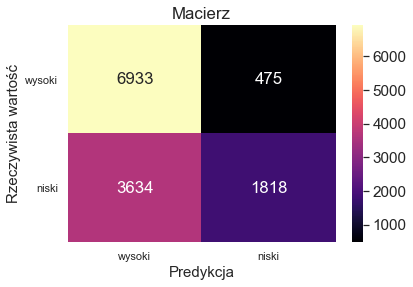

<Figure size 1080x720 with 0 Axes>

In [73]:
#Wizualazicja dokładności predykcji na podstawie macierzy
labels = y_dclf.unique()
con_matrix = metrics.confusion_matrix(y_test_dclf, y_pred)
matrix_df = pd.DataFrame(con_matrix)
#Tworzenie macierzy
ax = plt.axes()
sns.set(font_scale=1.4)
plt.figure(figsize=(15,10))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Macierz')
ax.set_xlabel("Predykcja", fontsize=15)
ax.set_xticklabels(labels)
ax.set_ylabel("Rzeczywista wartość", fontsize=15)
ax.set_yticklabels(labels, rotation = 0)
plt.show()

Metoda sprawdzania jakie alfa wybrać do przycinania drzewa

Text(0, 0.5, 'Accuracy scores')

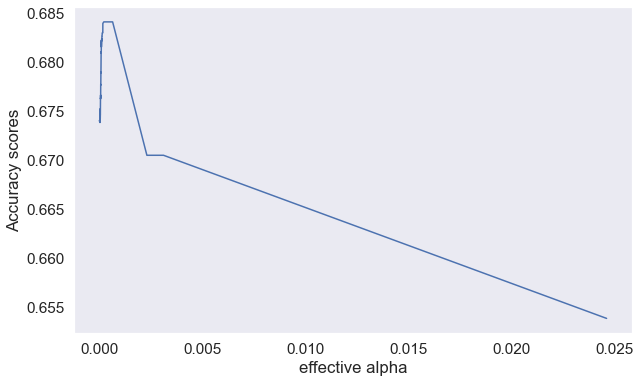

In [75]:
path = dec_clf.cost_complexity_pruning_path(x_train_dclf, y_train_dclf)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    dec_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, max_depth=11)
    dec_clf.fit(x_train_dclf, y_train_dclf)
    clfs.append(dec_clf)

acc_scores = [accuracy_score(y_test_dclf, dec_clf.predict(x_test_dclf)) for dec_clf in clfs]

tree_depths = [dec_clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

---

<u> Propozycja drzewa 2</u>: Dochody per capita, ludność na 1 km2, Wydatki na oświatę -> Skolaryzacja

In [76]:
df_dectree1 = pd.merge(gminy['Dochody per capita'][gminy['Dochody per capita'].Zmienna == 'ogółem'], gminy['Wydatki per capita'][gminy['Wydatki per capita'].Zmienna == 'w Dziale 801- Oświata i wychowanie'], how='left', on = ['Kod', 'Rok'])
df_dectree1 = df_dectree1.rename({'Wartosc_x': 'Dochody', 'Wartosc_y': 'Wydatki'}, axis=1)
df_dectree1 = pd.merge(df_dectree1, gminy['Ludność'][gminy['Ludność'].Zmienna == 'ludność na 1 km2'], how='left', on = ['Kod', 'Rok'])
df_dectree1 = pd.merge(df_dectree1, gminy['Skolaryzacja'][gminy['Skolaryzacja'].Zmienna == 'szkoły podstawowe'], how='left', on = ['Kod', 'Rok'])
df_dectree1 = df_dectree1.rename({'Wartosc_x': 'Ludnosc na km2', 'Wartosc_y': 'Skolaryzacja'}, axis=1)
df_dectree1 = df_dectree1.dropna()

df_dectree1 = df_dectree1[['Kod', 'Dochody', 'Wydatki', 'Skolaryzacja', 'Ludnosc na km2']]
df_dectree1 = df_dectree1.dropna()

def code(x):
  if x <= 90:
    return 'niski'
  else:
    return 'wysoki'

df_dectree1['Skolaryzacja'] = df_dectree1['Skolaryzacja'].apply(code)
df_dectree1['Skolaryzacja'] = df_dectree1['Skolaryzacja'].astype('string')
df_dectree1 = df_dectree1[~df_dectree1.Kod.isin(voiv_list)]
df_dectree1 = df_dectree1.loc[:, ~df_dectree1.columns.duplicated()]

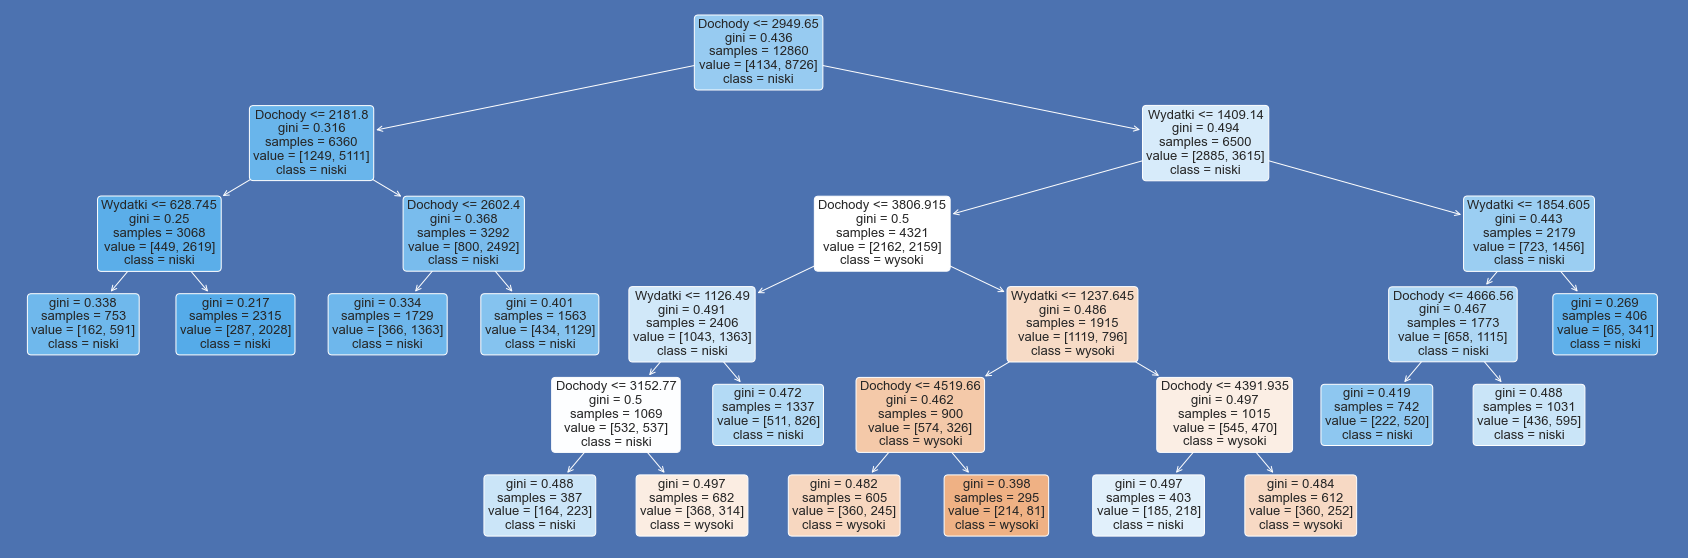

Dokładność: 0.7104199066874028


In [77]:
#Zmienne 
x_dclf = df_dectree1[['Dochody', 'Wydatki']]
#Klasa
y_dclf = df_dectree1['Skolaryzacja']
#Podział zmiennych na zbiór testowy oraz treningowy
x_train_dclf, x_test_dclf, y_train_dclf, y_test_dclf = train_test_split(x_dclf, y_dclf, test_size = 0.25)
#Algorytm drzew decyzyjnych oraz pruning na podstawie algorytmu
dec_clf1 = DecisionTreeClassifier(criterion="gini", ccp_alpha=0.0005)
#Uczenie algorytmu
dec_clf1 = dec_clf1.fit(x_test_dclf, y_test_dclf)
#Tworzenie predykcji
y_pred = dec_clf1.predict(x_test_dclf)

#Wizualizacja danych
plt.figure(figsize=(30,10), facecolor ='b')
a = tree.plot_tree(dec_clf1, feature_names = x_dclf.columns, class_names=y_dclf.unique(), rounded = True, filled = True, fontsize=13)
plt.show()
#Dokładność danych:
print("Dokładność:",metrics.accuracy_score(y_test_dclf, y_pred))

Wizualizacja dokładności predykcji na podstawie macierzy

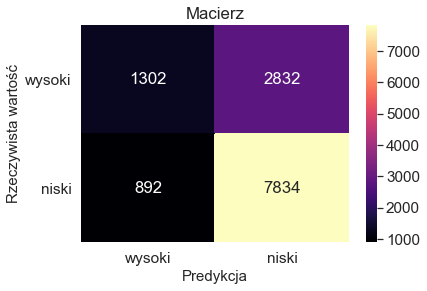

<Figure size 1080x720 with 0 Axes>

In [78]:
labels = y_dclf.unique()
con_matrix = metrics.confusion_matrix(y_test_dclf, y_pred)
matrix_df = pd.DataFrame(con_matrix)
#Tworzenie macierzy
ax = plt.axes()
sns.set(font_scale=1.4)
plt.figure(figsize=(15,10))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Macierz')
ax.set_xlabel("Predykcja", fontsize=15)
ax.set_xticklabels(labels)
ax.set_ylabel("Rzeczywista wartość", fontsize=15)
ax.set_yticklabels(labels, rotation = 0)
plt.show()

Metoda sprawdzania jakie alfa wybrać do przycinania drzewa

Text(0, 0.5, 'Accuracy scores')

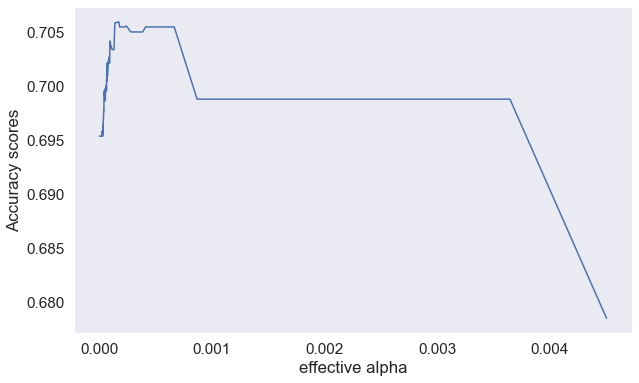

In [79]:
path = dec_clf1.cost_complexity_pruning_path(x_train_dclf, y_train_dclf)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    dec_clf1 = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, max_depth=11)
    dec_clf1.fit(x_train_dclf, y_train_dclf)
    clfs.append(dec_clf1)

acc_scores = [accuracy_score(y_test_dclf, dec_clf1.predict(x_test_dclf)) for dec_clf1 in clfs]

tree_depths = [dec_clf1.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

## 4.3. Analiza rozkładu zmiennej
**Średnie wydatki miesięczne w latach 2016-2020**

In [80]:
data = ludnosc['Wydatki'][ludnosc['Wydatki']['Rok']>2015]
data = data[data['Zmienna']=='ogółem']['Wartosc']
print('Wielkość próbki:', len(data))
data.head()
print('Średnia=%.3f \nOdchylenie standardowe=%.3f' % (np.mean(data), np.std(data)))

Wielkość próbki: 85
Średnia=1159.306 
Odchylenie standardowe=134.500


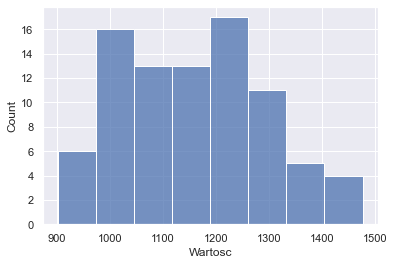

In [82]:
sns.set_theme()
ax = sns.histplot(data)

**Q-Q Plot** (kwantyl-kwantyl)<br>
Porównanie wartości empirycznej i teoretycznej kwantyli. <br>
Rozkład jest dobrze dopasowany, gdy punkty na wykresie znajdują się na wykresie funkcji y=x lub bardzo blisko i są równomiernie rozłożone po jej jednej i drugiej stronie.

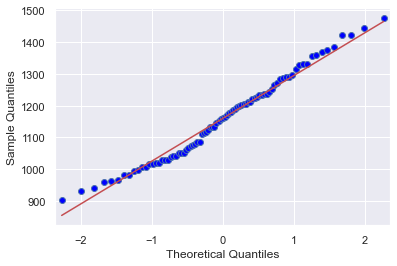

In [85]:
qqplot(data, line='s')
plt.show()

Test normalności rozkładu **Shapiro-Wilka**

In [86]:
print('Hipoteza zerowa H0: ten rozkład jest normalny')
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Hipoteza zerowa H0: ten rozkład jest normalny
Statistics=0.978, p=0.147
Sample looks Gaussian (fail to reject H0)


95% przedział ufności dla średnich miesięcznych wydatków:

In [87]:
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(1130.122278054954, 1188.4887807685761)

## 4.4. Algorytm K-Means

In [88]:
df = pd.merge(gminy['Bezrobocie'][gminy['Bezrobocie'].Zmienna == 'ogółem'], gminy['Wydatki per capita'][gminy['Wydatki per capita'].Zmienna == 'ogółem'], how='left', on = ['Kod', 'Rok'])
df = df.rename({'Wartosc_x': 'Bezrobocie', 'Wartosc_y': 'Wydatki'}, axis=1)
df = pd.merge(df, gminy['Dochody per capita'][gminy['Dochody per capita'].Zmienna == 'ogółem'], how='left', on = ['Kod', 'Rok'])
df = pd.merge(df, gminy['Ludność'][gminy['Ludność'].Zmienna == 'przyrost naturalny na 1000 ludności'], how='left', on = ['Kod', 'Rok'])
df = df.rename({'Wartosc_x': 'Dochody', 'Wartosc_y': 'Przyrost naturalny'}, axis=1)
df = df.dropna()
df = df[['Bezrobocie', 'Dochody', 'Przyrost naturalny']]
df

Bezrobocie   Dochody  Przyrost naturalny
0            13.2   1662.00               -0.37
1            12.4   1887.00               -0.19
2            11.4   2151.00               -0.10
3             9.4   2431.28                0.12
4             7.1   2725.28                0.28
...           ...       ...                 ...
76081         3.1   8043.11               -3.82
76082         2.9   8082.01               -3.56
76083         2.5   9170.99               -5.25
76084         2.0   7860.86               -4.13
76085         3.0  14753.11               -4.77

[51743 rows x 3 columns]

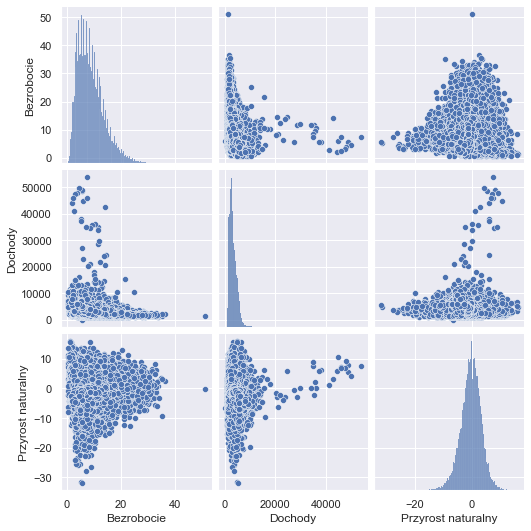

In [89]:
sns.set_theme()
sns.pairplot(df, kind="scatter")
plt.show()

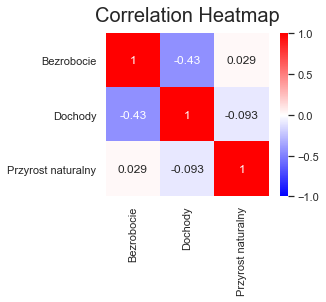

In [90]:
f, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(df.corr(), square=True, vmin=-1, vmax=1, annot=True, cmap='bwr', ax=ax)
ax.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

In [91]:
df = df[['Dochody','Bezrobocie']]
df = pd.DataFrame({'Dochody':list(df['Dochody']), 'Bezrobocie' :list(df['Bezrobocie'])})

**Metoda wykresu łokciowego dla optymalnego k**

* **Distortion**: Jest obliczane jako średnia z kwadratów odległości od centrów klastrów odpowiednich klastrów. Zazwyczaj używana jest metryka odległości euklidesowej.

* **Inertia**: Jest to suma kwadratów odległości próbek do ich najbliższego centrum klastra.

Iterujemy wartości k (np. od 1 do 15) i obliczamy wartości distortion dla każdej wartości k.

[[1, 138368433136.7572], [2, 66755686592.94846], [3, 37578167139.76553], [4, 22606523472.227543], [5, 15274166995.285086], [6, 11072186383.561043], [7, 8667428201.31413], [8, 6821885883.960909], [9, 5463086036.021296], [10, 4415220373.568957], [11, 3720708638.6083035], [12, 3136033380.221332], [13, 2608672677.5152726], [14, 2246622147.5896697]]


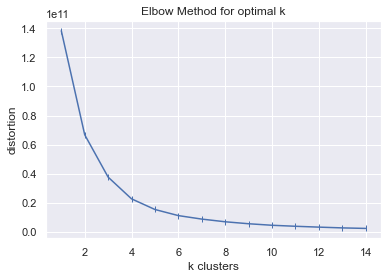

In [94]:
distortion = []
for k in range(1,15):
    km = KMeans(n_clusters = k, random_state=0)
    km.fit(df)
    distortion.append([k,km.inertia_])
print(distortion)

sns.set_theme()
plt.plot([k[0] for k in distortion],[k[1] for k in distortion], 'b|-')
plt.xlabel('k clusters')
plt.ylabel('distortion')
plt.title('Elbow Method for optimal k')
plt.show()

**k=4**

In [98]:
km = KMeans(n_clusters=4)
km.fit(df)
print(km.labels_[:15])
km.cluster_centers_

[1 1 1 1 1 0 0 0 0 0 0 0 0 0 2]


array([[3.60165185e+03, 8.04248907e+00],
       [2.11503321e+03, 1.11286174e+01],
       [5.63893654e+03, 5.27051892e+00],
       [3.84904715e+04, 7.67692308e+00]])

Text(0, 0.5, 'Bezrobocie')

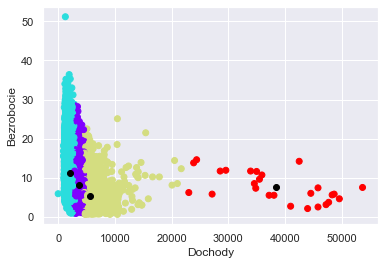

In [101]:
plt.scatter(df['Dochody'],df['Bezrobocie'], c=km.labels_, cmap='rainbow')
plt.scatter(km.cluster_centers_[:,0] ,km.cluster_centers_[:,1], color='black')
plt.xlabel('Dochody')
plt.ylabel('Bezrobocie')

In [100]:
fig = px.scatter(data_frame=df,
        x=df['Dochody'],
        y=df['Bezrobocie'],
        color=km.labels_
    )
fig.show()

**k=6**

In [102]:
km = KMeans(n_clusters=6)
km.fit(df)
print(km.labels_[:15])
km.cluster_centers_

[2 2 2 4 4 4 4 4 0 0 0 0 0 0 3]


array([[4.00902991e+03, 7.08826544e+00],
       [3.91084424e+04, 7.73600000e+00],
       [1.79958700e+03, 1.23388175e+01],
       [5.39122963e+03, 5.30189632e+00],
       [2.83645783e+03, 9.25227872e+00],
       [7.84498348e+03, 4.76734300e+00]])

Text(0, 0.5, 'Bezrobocie')

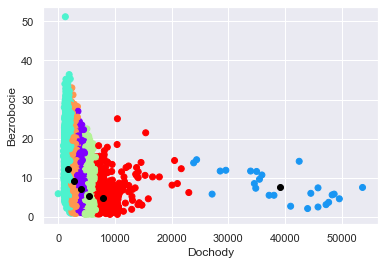

In [103]:
plt.scatter(df['Dochody'],df['Bezrobocie'], c=km.labels_, cmap='rainbow')
plt.scatter(km.cluster_centers_[:,0] ,km.cluster_centers_[:,1], color='black')
plt.xlabel('Dochody')
plt.ylabel('Bezrobocie')